# Feature Engineering (Part-1)

<b><font color='blue'>The goal of this case study is to build a predictive model that a machine will fail in the next 24 hours due to a certain component failure (component 1, 2, 3, or 4) or not.</b>

During EDA of the data sets it is observed that data sets are having time-stamps. <br> 
So, we need to create new features relevant to time series analysis for our predictive model.
The first step in predictive model is feature engineering which requires bringing the different data sources together to create features that best describe a machine's health condition at a given point in time. In the next sections, several feature engineering methods will be used to create features based on the properties/attributes/features of each data source.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
#Importing libraries
import os
import sys
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("Solarize_Light2")
%matplotlib inline

In [3]:
#Loading all the dataset using Pandas library from gdrive
import pandas as pd

telemetry = pd.read_csv('/content/drive/MyDrive/AAIC/Case_study_1/PdM_telemetry.csv')
errors = pd.read_csv('/content/drive/MyDrive/AAIC/Case_study_1/PdM_errors.csv')
maint = pd.read_csv('/content/drive/MyDrive/AAIC/Case_study_1/PdM_maint.csv')
failures = pd.read_csv('/content/drive/MyDrive/AAIC/Case_study_1/PdM_failures.csv')
machines = pd.read_csv('/content/drive/MyDrive/AAIC/Case_study_1/PdM_machines.csv')

In [4]:
# #Loading all the datasets using Pandas library from local PC
# import pandas as pd

# telemetry = pd.read_csv('PdM_telemetry.csv')
# errors = pd.read_csv('PdM_errors.csv')
# maint = pd.read_csv('PdM_maint.csv')
# failures = pd.read_csv('PdM_failures.csv')
# machines = pd.read_csv('PdM_machines.csv')

In [5]:
# Formating datetime field.
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
errors['errorID'] = errors['errorID'].astype('category')

maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint['comp'] = maint['comp'].astype('category')

machines['model'] = machines['model'].astype('category')

failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

## Lag Features from Telemetry data
Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.

Telemetry data comes with time-stamps which makes it suitable for calculating lagging features. A common method is to pick a window size for the lag features to be created and compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over the lag window. In the following, we will create only <b> 2 nos features 'min and max' of the telemetry data </b> over the last 3 hour lag window will be calculated for every 3 hours with pandas's function "resample".

- Reference: https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/
<br>#Reference: https://stackoverflow.com/questions/45370666/what-are-pandas-expanding-window-functions
<br>#Reference: https://towardsdatascience.com/using-the-pandas-resample-function-a231144194c4

In [6]:
# Calculate "resample min values" over the last 3 hour lag window for telemetry features.
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                        values=col).resample('3H', closed='left', label='right').min().unstack())

telemetry_min_3h = pd.concat(temp, axis=1)
telemetry_min_3h.columns = [i + '_min_3h' for i in fields]
telemetry_min_3h.reset_index(inplace=True)

telemetry_min_3h.head()

,machineID,datetime,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h
0,1,2015-01-01 09:00:00,162.879223,402.747490,75.237905,34.178847
1,1,2015-01-01 12:00:00,157.610021,346.149335,95.927042,25.990511
2,1,2015-01-01 15:00:00,156.556031,398.648781,101.001083,35.482009
3,1,2015-01-01 18:00:00,160.263954,382.483543,96.480976,38.543681
4,1,2015-01-01 21:00:00,153.353492,402.461187,86.012440,39.739883


In [7]:
# Calculate "resample max values" over the last 3 hour lag window for telemetry features.
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                        values=col).resample('3H', closed='left', label='right').max().unstack())

telemetry_max_3h = pd.concat(temp, axis=1)
telemetry_max_3h.columns = [i + '_max_3h' for i in fields]
telemetry_max_3h.reset_index(inplace=True)

telemetry_max_3h.head()

,machineID,datetime,volt_max_3h,rotate_max_3h,pressure_max_3h,vibration_max_3h
0,1,2015-01-01 09:00:00,176.217853,527.349825,113.077935,45.087686
1,1,2015-01-01 12:00:00,172.504839,435.376873,111.886648,41.122144
2,1,2015-01-01 15:00:00,175.324524,499.071623,111.755684,45.482287
3,1,2015-01-01 18:00:00,169.218423,460.850670,104.848230,42.675800
4,1,2015-01-01 21:00:00,182.739113,490.672921,93.484954,44.108554


<b>Now, the above new columns of the feature datasets will be merged below to create the final features set from telemetry.

In [8]:
# Merge columns of feature sets created earlier
telemetry_feat = pd.concat([telemetry_min_3h,
                            telemetry_max_3h.iloc[:, 2:6]], axis=1).dropna()

telemetry_feat.head()

,machineID,datetime,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,volt_max_3h,rotate_max_3h,pressure_max_3h,vibration_max_3h
0,1,2015-01-01 09:00:00,162.879223,402.747490,75.237905,34.178847,176.217853,527.349825,113.077935,45.087686
1,1,2015-01-01 12:00:00,157.610021,346.149335,95.927042,25.990511,172.504839,435.376873,111.886648,41.122144
2,1,2015-01-01 15:00:00,156.556031,398.648781,101.001083,35.482009,175.324524,499.071623,111.755684,45.482287
3,1,2015-01-01 18:00:00,160.263954,382.483543,96.480976,38.543681,169.218423,460.850670,104.848230,42.675800
4,1,2015-01-01 21:00:00,153.353492,402.461187,86.012440,39.739883,182.739113,490.672921,93.484954,44.108554


In [9]:
telemetry_feat.describe()

,machineID,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,volt_max_3h,rotate_max_3h,pressure_max_3h,vibration_max_3h
count,292100.000000,292100.000000,292100.000000,292100.000000,292100.000000,292100.000000,292100.000000,292100.000000,292100.000000
mean,50.500000,158.083149,404.146613,92.384876,36.149107,183.473398,489.026431,109.348395,44.627644
std,28.866119,11.878952,40.828783,8.783319,4.210114,11.909021,40.802190,8.863881,4.220441
min,1.000000,97.333604,138.432075,51.237106,14.877054,134.008631,237.641009,75.559302,28.581727
25%,25.750000,150.370836,379.505260,86.862827,33.457643,175.270539,463.319490,103.502795,41.787201
50%,50.500000,158.172629,406.891158,92.118675,36.088473,182.769923,489.161104,108.505756,44.291338
75%,75.250000,165.846384,432.062323,97.281361,38.667734,190.895306,515.375351,114.007202,47.039826
max,100.000000,235.726785,565.962115,160.026994,68.001841,255.124717,695.020984,185.951998,76.791072


### Lag Features from Errors dataset

Like telemetry data, errors data set comes with timestamps. An important difference is that the error IDs are categorical values and should not be averaged over time intervals like the telemetry measurements. Instead, we count the number of errors of each type in a lagging window. We begin by reformatting the error data to have one entry per machine per time at which at least one error occurred:

In [10]:
# Create a column for each error type
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']

# Combine errors for a given machine in a given hour
error_count = error_count.groupby(['machineID', 'datetime']).sum().reset_index()
error_count.head()

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0


Now, we will add feature 'datetime' and 'machineID' from telemetry data set and add blank entries for all other hourly timepoints (since no errors occurred at those times):

In [11]:
error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], 
                                                         how='left').fillna(0.0)

error_count.head()

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 08:00:00,1,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 09:00:00,1,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 10:00:00,1,0.0,0.0,0.0,0.0,0.0


In [12]:
error_count.describe()

,machineID,error1,error2,error3,error4,error5
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,0.001153,0.001128,0.000957,0.000830,0.000406
std,28.866087,0.033934,0.033563,0.030913,0.028795,0.020154
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<b>Finally, we can compute the total number of errors of each type over the last 24 hours, for timepoints taken every 3 hours:

In [13]:
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    temp.append(pd.pivot_table(error_count,
                                               index='datetime',
                                               columns='machineID',
                                         values=col).rolling(window=24).sum().resample('3H', 
                                                    closed='left', label='right').first().unstack())


error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
# error_count.reset_index(inplace=True)#To be activate
error_count = error_count.dropna()
error_count.head()

error1count  error2count  error3count  \
machineID datetime                                                     
1         2015-01-02 06:00:00          0.0          0.0          0.0   
          2015-01-02 09:00:00          0.0          0.0          0.0   
          2015-01-02 12:00:00          0.0          0.0          0.0   
          2015-01-02 15:00:00          0.0          0.0          0.0   
          2015-01-02 18:00:00          0.0          0.0          0.0   

                               error4count  error5count  
machineID datetime                                       
1         2015-01-02 06:00:00          0.0          0.0  
          2015-01-02 09:00:00          0.0          0.0  
          2015-01-02 12:00:00          0.0          0.0  
          2015-01-02 15:00:00          0.0          0.0  
          2015-01-02 18:00:00          0.0          0.0

In [14]:
error_count.describe()

,error1count,error2count,error3count,error4count,error5count
count,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,0.027649,0.027069,0.022907,0.019904,0.009753
std,0.166273,0.164429,0.151453,0.140820,0.098797
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000


### Count nos of Days Since Last Replacement of component from Maintenance data

A crucial data set in this example is the maintenance records which contain the information of component replacement records. Possible features from this data set can be, for example, the number of replacements of each component in the last 3 months to incorporate the frequency of replacements. However, more relevent information would be to calculate how long it has been since a component is last replaced as that would be expected to correlate better with component failures since the longer a component is used, the more degradation should be expected. 

As a side note, creating lagging features from maintenance data is not as straightforward as for telemetry and errors, so the features from this data are generated in a more custom way. This type of ad-hoc feature engineering is very common in predictive maintenance. In the following step, the numbers of days since last component replacement are calculated for each component type as features from the maintenance data. 

In [15]:
import numpy as np
from tqdm.notebook import tqdm_notebook

# Create a column for each error type
comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

# Combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# Add timepoints where no components were replaced
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                    on=['datetime', 'machineID'],
                                     how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])


components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in tqdm_notebook(components):
    # Convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(),'datetime']
    
    # Forward-fill the most-recent date of component change
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

# Remove dates in 2014 (may have NaN or future component change dates)    
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

# Replace dates of most recent component change with days since most recent component change
for comp in tqdm_notebook(components):
    comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]) / np.timedelta64(1, 'D')
    
comp_rep.describe()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,machineID,comp1,comp2,comp3,comp4
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,53.525185,51.540806,52.725962,53.834191
std,28.866087,62.491679,59.269254,58.873114,59.707978
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,13.291667,12.125000,13.125000,13.000000
50%,50.500000,32.791667,29.666667,32.291667,32.500000
75%,75.250000,68.708333,66.541667,67.333333,70.458333
max,100.000000,491.958333,348.958333,370.958333,394.958333


In [16]:
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1,19.166667,214.166667,154.166667,169.166667


### Machine Features

The machine features can be used without further modification. These include descriptive information about the type of each machine and its age (number of years in service). If the age information had been recorded as a "first use date" for each machine, a transformation would have been necessary to turn those into a numeric values indicating the years in service.

<b>Lastly, we merge all the feature data sets we created above to get the final feature matrix.

In [17]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

print(final_feat.head())
final_feat.describe()

   machineID            datetime  volt_min_3h  rotate_min_3h  pressure_min_3h  \
0          1 2015-01-01 09:00:00   162.879223     402.747490        75.237905   
1          1 2015-01-01 12:00:00   157.610021     346.149335        95.927042   
2          1 2015-01-01 15:00:00   156.556031     398.648781       101.001083   
3          1 2015-01-01 18:00:00   160.263954     382.483543        96.480976   
4          1 2015-01-01 21:00:00   153.353492     402.461187        86.012440   

   vibration_min_3h  volt_max_3h  rotate_max_3h  pressure_max_3h  \
0         34.178847   176.217853     527.349825       113.077935   
1         25.990511   172.504839     435.376873       111.886648   
2         35.482009   175.324524     499.071623       111.755684   
3         38.543681   169.218423     460.850670       104.848230   
4         39.739883   182.739113     490.672921        93.484954   

   vibration_max_3h  ...  error2count  error3count  error4count  error5count  \
0         45.087686  ...

,machineID,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,volt_max_3h,rotate_max_3h,pressure_max_3h,vibration_max_3h,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,292100.000000,292100.000000,292100.000000,292100.000000,292100.000000,292100.000000,292100.000000,292100.000000,292100.000000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000,292000.000000,292000.000000,292000.000000,292000.000000,292100.000000
mean,50.500000,158.083149,404.146613,92.384876,36.149107,183.473398,489.026431,109.348395,44.627644,0.027649,0.027069,0.022907,0.019904,0.009753,53.464473,51.475866,52.660493,53.769068,11.330000
std,28.866119,11.878952,40.828783,8.783319,4.210114,11.909021,40.802190,8.863881,4.220441,0.166273,0.164429,0.151453,0.140820,0.098797,62.479594,59.251179,58.856793,59.692723,5.827625
min,1.000000,97.333604,138.432075,51.237106,14.877054,134.008631,237.641009,75.559302,28.581727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,150.370836,379.505260,86.862827,33.457643,175.270539,463.319490,103.502795,41.787201,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.125000,13.125000,13.000000,6.750000
50%,50.500000,158.172629,406.891158,92.118675,36.088473,182.769923,489.161104,108.505756,44.291338,0.000000,0.000000,0.000000,0.000000,0.000000,32.750000,29.625000,32.250000,32.500000,12.000000
75%,75.250000,165.846384,432.062323,97.281361,38.667734,190.895306,515.375351,114.007202,47.039826,0.000000,0.000000,0.000000,0.000000,0.000000,68.625000,66.500000,67.250000,70.375000,16.000000
max,100.000000,235.726785,565.962115,160.026994,68.001841,255.124717,695.020984,185.951998,76.791072,2.000000,2.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000


## Label Construction

When using multi-class classification for predicting failure due to a problem, labelling is done by taking a time window prior to the failure of an asset and labelling the feature records that fall into that window as "about to fail due to a problem" while labelling all other records as "normal". This time window should be picked according to the business case: in some situations it may be enough to predict failures hours in advance, while in others days or weeks may be needed to allow e.g. for arrival of replacement parts.

The prediction problem for this example scenario is to predict that a machine will fail in the near future due to a failure of a certain component or not. More specifically, <b>the goal is to predict that a machine will fail in the next 24 hours due to a certain component failure (component 1, 2, 3, or 4)</b> or not. Below, a categorical `failure` feature is created to serve as the label. All records within a 24 hour window before a failure of component 1 have `failure=comp1`, and so on for components 2, 3, and 4; all records not within 24 hours of a component failure have `failure=none`.

In [18]:
labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
labeled_features['failure'] = labeled_features['failure'].astype('str')
labeled_features.replace({'nan': "none"}, inplace= True)

In [19]:
labeled_features.head(2)

,machineID,datetime,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,volt_max_3h,rotate_max_3h,pressure_max_3h,vibration_max_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-01 09:00:00,162.879223,402.747490,75.237905,34.178847,176.217853,527.349825,113.077935,45.087686,...,0.0,0.0,0.0,19.125,214.125,154.125,169.125,model3,18,none
1,1,2015-01-01 12:00:00,157.610021,346.149335,95.927042,25.990511,172.504839,435.376873,111.886648,41.122144,...,0.0,0.0,0.0,19.250,214.250,154.250,169.250,model3,18,none


Below is an example of records that are labeled as failure=comp4 in the failure column. Notice that the first 8 records all occur in the 24-hour window before the first recorded failure of component 4. The next 8 records are within the 24 hour window before another failure of component 4.

In [20]:
labeled_features.loc[labeled_features['failure'] == 'comp4'][:16]

,machineID,datetime,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,volt_max_3h,rotate_max_3h,pressure_max_3h,vibration_max_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
24,1,2015-01-04 09:00:00,142.666469,433.279499,97.709630,48.238941,191.168936,479.615136,118.853452,54.848731,...,1.0,0.0,1.0,22.125,217.125,157.125,172.125,model3,18,comp4
25,1,2015-01-04 12:00:00,153.143558,438.091311,94.524894,51.647981,215.656488,458.097746,113.100915,57.411078,...,1.0,0.0,1.0,22.250,217.250,157.250,172.250,model3,18,comp4
26,1,2015-01-04 15:00:00,129.016707,421.728389,91.675576,45.951349,173.525320,479.457721,111.575038,50.458297,...,1.0,0.0,1.0,22.375,217.375,157.375,172.375,model3,18,comp4
27,1,2015-01-04 18:00:00,168.503141,365.213804,82.400818,43.917862,184.640476,517.348533,87.474009,52.048152,...,1.0,0.0,1.0,22.500,217.500,157.500,172.500,model3,18,comp4
28,1,2015-01-04 21:00:00,183.684832,414.481164,103.159963,41.674887,199.755983,427.763970,111.684659,56.837165,...,1.0,0.0,1.0,22.625,217.625,157.625,172.625,model3,18,comp4
29,1,2015-01-05 00:00:00,162.368945,447.101400,89.260131,50.240045,180.562703,471.194987,95.748683,62.464103,...,0.0,0.0,1.0,22.750,217.750,157.750,172.750,model3,18,comp4
30,1,2015-01-05 03:00:00,127.163620,376.719605,89.969588,46.845600,161.928938,430.475185,95.667178,58.225151,...,0.0,0.0,1.0,22.875,217.875,157.875,172.875,model3,18,comp4
31,1,2015-01-05 06:00:00,177.317220,387.005318,94.686208,45.202347,202.520488,469.787301,103.056344,59.577251,...,0.0,0.0,1.0,0.000,218.000,158.000,0.000,model3,18,comp4
1344,1,2015-06-18 09:00:00,142.165191,417.834555,96.780895,51.105583,198.380679,500.852906,110.190707,55.884000,...,0.0,0.0,1.0,89.125,29.125,14.125,134.125,model3,18,comp4
1345,1,2015-06-18 12:00:00,184.681384,387.342414,91.050336,40.747029,197.240367,474.031690,105.660885,49.345127,...,0.0,0.0,1.0,89.250,29.250,14.250,134.250,model3,18,comp4


In [22]:
# #Save pre-processed data in CSV.
# labeled_features.to_csv('/content/drive/MyDrive/AAIC/Case_study_1/preprocessed_1.csv', encoding='utf-8', index=False)

## Modeling

After the feature engineering and labeling steps, below, modeling process is being described. 

### Training, Validation and Testing

When working with time-stamped data as in this example, record partitioning into training, validation, and test sets should be performed carefully to prevent overestimating the performance of the models. In predictive maintenance, the features are usually generated using lagging aggregates: records in the same time window will likely have identical labels and similar feature values. These correlations can give a model an "unfair advantage" when predicting on a test set record that shares its time window with a training set record. We therefore partition records into training, validation, and test sets in large chunks, to minimize the number of time intervals shared between them.

Predictive models have no advance knowledge of future chronological trends: in practice, such trends are likely to exist and to adversely impact the model's performance. To obtain an accurate assessment of a predictive model's performance, it is recommended to train on older records and validating/testing using newer records.

For both of these reasons, a time-dependent record splitting strategy is an excellent choice for predictive maintenance models. The featured dataset has been splitted into three dataset "Training", "Cross Validation and "Test" dataset with time.

### <b> All the featured dataset has been saved in "preprocessed.csv" for ease of analysis.

In [4]:
# #Importing the "preprocessed.csv".
import pandas as pd
labeled_features= pd.read_csv("/content/drive/MyDrive/AAIC/Case_study_1/preprocessed_1.csv")
# Format datetime field which comes in as string

labeled_features['datetime'] = pd.to_datetime(labeled_features['datetime'], format="%Y-%m-%d %H:%M:%S")

In [7]:
labeled_features.head(2)

,machineID,datetime,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,volt_max_3h,rotate_max_3h,pressure_max_3h,vibration_max_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-01 09:00:00,162.879223,402.747490,75.237905,34.178847,176.217853,527.349825,113.077935,45.087686,...,0.0,0.0,0.0,19.125,214.125,154.125,169.125,model3,18,none
1,1,2015-01-01 12:00:00,157.610021,346.149335,95.927042,25.990511,172.504839,435.376873,111.886648,41.122144,...,0.0,0.0,0.0,19.250,214.250,154.250,169.250,model3,18,none


In [8]:
labeled_features.tail(2)

,machineID,datetime,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,volt_max_3h,rotate_max_3h,pressure_max_3h,vibration_max_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
292140,100,2016-01-01 06:00:00,165.475310,413.77167,94.132837,35.123072,192.483414,447.816524,104.081073,48.314561,...,0.0,0.0,0.0,83.0,8.0,83.0,53.0,model4,5,none
292141,100,2016-01-01 09:00:00,171.336037,496.09687,79.095538,37.845245,171.336037,496.096870,79.095538,37.845245,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,model4,5,none


In [9]:
labeled_features.describe()

,machineID,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,volt_max_3h,rotate_max_3h,pressure_max_3h,vibration_max_3h,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,292142.000000,292142.000000,292142.000000,292142.000000,292142.000000,292142.000000,292142.000000,292142.000000,292142.000000,292141.000000,292141.000000,292141.000000,292141.000000,292141.000000,292141.000000,292141.000000,292141.000000,292141.000000,292142.000000
mean,50.499127,158.084403,404.139147,92.386747,36.149700,183.475185,489.018718,109.349751,44.628399,0.027815,0.027165,0.022989,0.019946,0.009834,53.479968,51.493181,52.679392,53.785669,11.330291
std,28.866542,11.880281,40.835358,8.786371,4.210870,11.911030,40.808835,8.866472,4.221378,0.166759,0.164698,0.151707,0.140960,0.099198,62.492435,59.265420,58.868352,59.704044,5.827542
min,1.000000,97.333604,138.432075,51.237106,14.877054,134.008631,237.641009,75.559302,28.581727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,150.371360,379.495432,86.863417,33.457799,175.270908,463.308453,103.502904,41.787266,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.125000,13.125000,13.000000,7.000000
50%,50.000000,158.173045,406.887098,92.119195,36.088670,182.771283,489.156358,108.506359,44.291599,0.000000,0.000000,0.000000,0.000000,0.000000,32.750000,29.625000,32.250000,32.500000,12.000000
75%,75.000000,165.847573,432.060311,97.282725,38.668287,190.897064,515.371091,114.008179,47.040771,0.000000,0.000000,0.000000,0.000000,0.000000,68.625000,66.500000,67.250000,70.375000,16.000000
max,100.000000,235.726785,565.962115,160.026994,68.001841,255.124717,695.020984,185.951998,76.791072,2.000000,2.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000


In [10]:
#https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8
#https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

### <b> Split the "preprocessed.csv" with Sklearn "train_test_split" function with "shuffle=False".

In [11]:
X = labeled_features.drop(['datetime', 'machineID', 'failure'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [12]:
X.head(2)

,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,volt_max_3h,rotate_max_3h,pressure_max_3h,vibration_max_3h,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age
0,162.879223,402.747490,75.237905,34.178847,176.217853,527.349825,113.077935,45.087686,0.0,0.0,0.0,0.0,0.0,19.125,214.125,154.125,169.125,model3,18
1,157.610021,346.149335,95.927042,25.990511,172.504839,435.376873,111.886648,41.122144,0.0,0.0,0.0,0.0,0.0,19.250,214.250,154.250,169.250,model3,18


In [13]:
X_final = pd.get_dummies(X)
X_final.head(2)

,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,volt_max_3h,rotate_max_3h,pressure_max_3h,vibration_max_3h,error1count,error2count,...,error5count,comp1,comp2,comp3,comp4,age,model_model1,model_model2,model_model3,model_model4
0,162.879223,402.747490,75.237905,34.178847,176.217853,527.349825,113.077935,45.087686,0.0,0.0,...,0.0,19.125,214.125,154.125,169.125,18,0,0,1,0
1,157.610021,346.149335,95.927042,25.990511,172.504839,435.376873,111.886648,41.122144,0.0,0.0,...,0.0,19.250,214.250,154.250,169.250,18,0,0,1,0


In [14]:
X_final.describe()

,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,volt_max_3h,rotate_max_3h,pressure_max_3h,vibration_max_3h,error1count,error2count,...,error5count,comp1,comp2,comp3,comp4,age,model_model1,model_model2,model_model3,model_model4
count,292142.000000,292142.000000,292142.000000,292142.000000,292142.000000,292142.000000,292142.000000,292142.000000,292141.000000,292141.000000,...,292141.000000,292141.000000,292141.000000,292141.000000,292141.000000,292142.000000,292142.000000,292142.000000,292142.000000,292142.000000
mean,158.084403,404.139147,92.386747,36.149700,183.475185,489.018718,109.349751,44.628399,0.027815,0.027165,...,0.009834,53.479968,51.493181,52.679392,53.785669,11.330291,0.160025,0.170003,0.349980,0.319992
std,11.880281,40.835358,8.786371,4.210870,11.911030,40.808835,8.866472,4.221378,0.166759,0.164698,...,0.099198,62.492435,59.265420,58.868352,59.704044,5.827542,0.366630,0.375636,0.476964,0.466474
min,97.333604,138.432075,51.237106,14.877054,134.008631,237.641009,75.559302,28.581727,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,150.371360,379.495432,86.863417,33.457799,175.270908,463.308453,103.502904,41.787266,0.000000,0.000000,...,0.000000,13.250000,12.125000,13.125000,13.000000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,158.173045,406.887098,92.119195,36.088670,182.771283,489.156358,108.506359,44.291599,0.000000,0.000000,...,0.000000,32.750000,29.625000,32.250000,32.500000,12.000000,0.000000,0.000000,0.000000,0.000000
75%,165.847573,432.060311,97.282725,38.668287,190.897064,515.371091,114.008179,47.040771,0.000000,0.000000,...,0.000000,68.625000,66.500000,67.250000,70.375000,16.000000,0.000000,0.000000,1.000000,1.000000
max,235.726785,565.962115,160.026994,68.001841,255.124717,695.020984,185.951998,76.791072,2.000000,2.000000,...,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
X_final_train = X_final.values
X_final_train[1]

array([157.61002119, 346.14933504,  95.92704169,  25.990511  ,
       172.5048392 , 435.37687302, 111.88664821,  41.12214409,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  19.25      , 214.25      , 154.25      ,
       169.25      ,  18.        ,   0.        ,   0.        ,
         1.        ,   0.        ])

In [16]:
y_final=labeled_features['failure']
y_final.head(2)

0    none
1    none
Name: failure, dtype: object

In [17]:
y_final_train = y_final.values
y_final_train[1]

'none'

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_final_train, y_final_train,test_size=0.20, shuffle=False)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, shuffle=False)

In [19]:
print('X_train Observations: %d' % (len(X_train)))
print('y_train Observations: %d' % (len(y_train)))

print('X_cv Observations: %d' % (len(X_cv)))
print('y_cv Observations: %d' % (len(y_cv)))

print('X_test Observations: %d' % (len(X_test)))
print('y_test Observations: %d' % (len(y_test)))

X_train Observations: 186970
y_train Observations: 186970
X_cv Observations: 46743
y_cv Observations: 46743
X_test Observations: 58429
y_test Observations: 58429


In [20]:
#Reference: AAIC Case_study_2.
# This function plots the confusion matrices given y_i, y_i_hat.
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = ['comp1', 'comp2', 'comp3', 'comp4', 'none']
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## Apply model XGBClassifier

In [21]:
from xgboost import XGBClassifier

x_cfl=XGBClassifier()
x_cfl.fit(X_train,y_train)

XGBClassifier(objective='multi:softprob')

-------------------- Confusion matrix --------------------


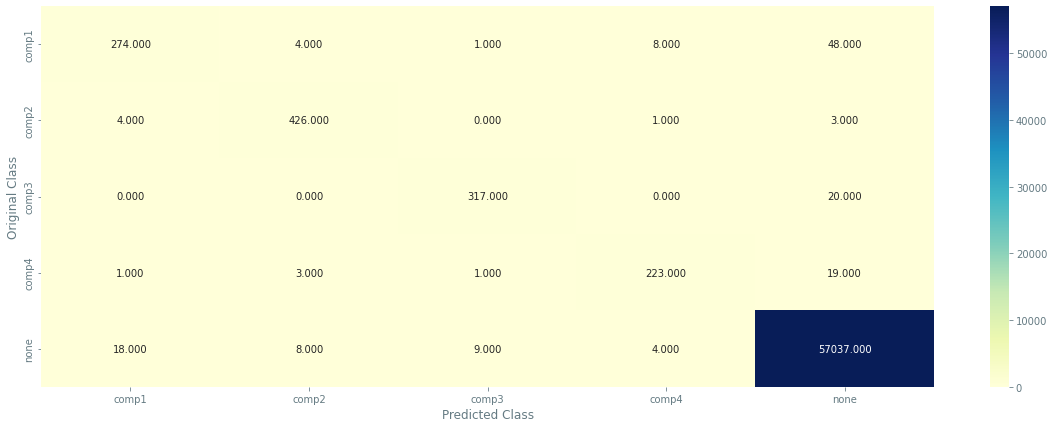

-------------------- Precision matrix (Columm Sum=1) --------------------


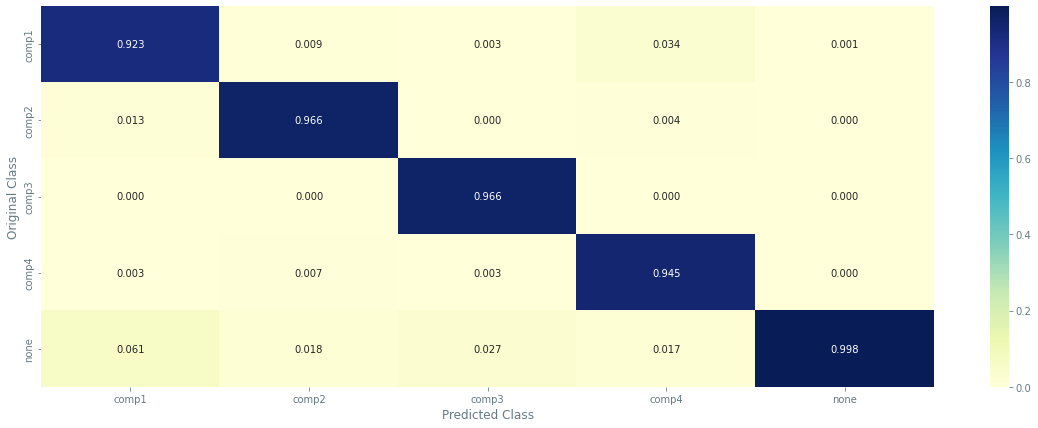

-------------------- Recall matrix (Row sum=1) --------------------


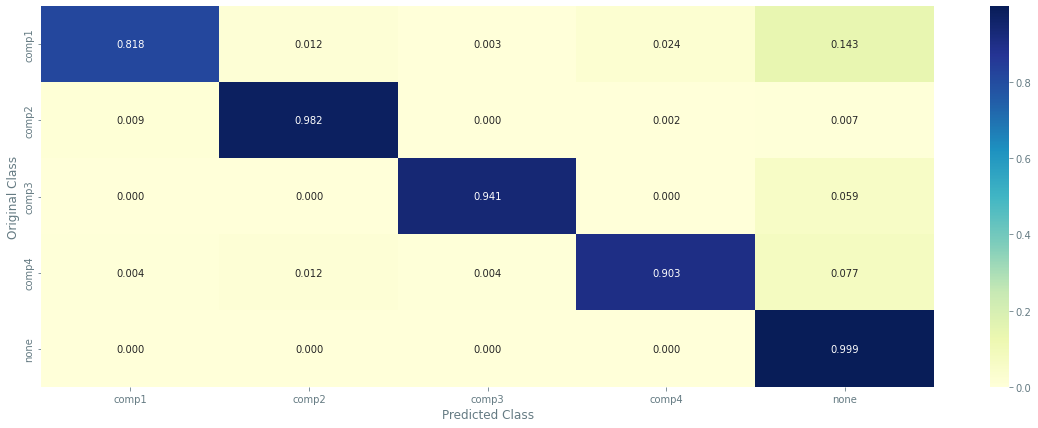

In [24]:
plot_confusion_matrix(y_test, x_cfl.predict(X_test))

In [31]:
from prettytable import PrettyTable

# Specify the Column Names
myTable = PrettyTable(["Model name (Recall score )", "comp1", "comp2", "comp3", 'comp4', 'none(no fail)'])

# Add rows

myTable.add_row(["Xgboost with available 19 nos of features", 
                 "0.206", "0.366", "0.639", "0.556", "1"])

myTable.add_row(["Xgboost with new 22 nos of features", 
                 "0.818", "0.982", "0.941", "0.903", "1"])


print(myTable)


+-------------------------------------------+-------+-------+-------+-------+---------------+
|         Model name (Recall score )        | comp1 | comp2 | comp3 | comp4 | none(no fail) |
+-------------------------------------------+-------+-------+-------+-------+---------------+
| Xgboost with available 19 nos of features | 0.206 | 0.366 | 0.639 | 0.556 |       1       |
|    Xgboost with new 22 nos of features    | 0.818 | 0.982 | 0.941 | 0.903 |       1       |
+-------------------------------------------+-------+-------+-------+-------+---------------+


# Observation on the above approach:
We are more concerned about the miss-classified data  points/even predicted by our predictive model, so we will monitor the 'Recall' metric of the computed model. If recall value of comp1 is 0.80, this means our model identified 80% of comp1 failure correctly. From the above table, it is observed 
recall value of all the failure components has increased a lot after creating new features (without performing  hyper-parameter tuning).

# Next step:
1. New lag features will be created and compute rolling aggregate measures of "mean and standard deviation" to represent the short term history of the telemetry over the lag window in the next Part-2 of FE. 
2. For capturing a longer term effect, 24 hour lag features of telemetry will be created.
3. All the feature created in FE_Part-1 and FE_Part-2 will be merged to build final feature set from telemetry.

# >>>>>>>> End of "FE_Case_study_1_part_1" <<<<<<<<